In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import brentq
import FCT1D as FCT
import Vfinder as VF

In [3]:
# Constants and Parameters
xlength = 20      # Total length of the grid
nx = 500          # Number of grid points

x0 = -6          # Initial coordinate in real space
eta = np.linspace(x0, -x0, nx)

In [4]:
def initialize_conditions(condition_type):
    """
    Initialize the flow problem based on the specified initial condition type.

    Parameters:
        condition_type (str): 'bjorken' or 'landau', defining the initial profile.

    Returns:
        t0 (float): Initial time for evolution.
        nt (int): Number of timesteps.
        dx (float): Step size in space.
        dt (float): Timestep size.
        E (numpy.ndarray): Initial energy density array.
        u (numpy.ndarray): Initial velocity array (zero initially).
    """
    u = np.zeros(nx)  # Initial velocity array (zero)
    E = np.zeros(nx)  # Initial energy density array
    n = np.zeros(nx)  # Initial number density array
    
    if condition_type.lower() == 'bjorken':
        t0 = 1.0
        nt = 626            # Number of timesteps
        dx = xlength / nx   # Step size in space
        ds = 0.4            # CFL number
        dt = ds * dx        # Timestep size
        E = 15 * np.ones(nx)  # Uniform initial energy density
        n = 15 * np.ones(nx)  # Uniform initial energy density
        
    elif condition_type.lower() == 'landau':
        t0 = 500.0
        nt = 500            # Number of timesteps
        dx = 0.1            # Step size in space
        ds = 0.1            # CFL number
        dt = ds * dx * t0   # Timestep size adjusted for Landau profile
        E = Landau(eta, t0)  # Landau-Khalatnikov profile for initial energy density
        n = Landau(eta, t0)  # Landau-Khalatnikov profile for initial energy density
                
    elif condition_type.lower() == 'square_pulse':
        t0 = 1.0
        nt = 242            # Number of timesteps
        dx = xlength / nx   # Step size in space
        ds = 0.4            # CFL number
        dt = ds * dx        # Timestep size
        pulse_width = int(nx * 0.2)  # 20% of the domain length as pulse width
        pulse_start = nx // 2 - pulse_width // 2
        pulse_end = pulse_start + pulse_width
        E[pulse_start:pulse_end] = 50.0  # High energy density in the middle  
        u[pulse_start:pulse_end] = np.tanh(eta[pulse_start:pulse_end])
        n[pulse_start:pulse_end] = 50.0  # High energy density in the middle          

    else:
        raise ValueError("Invalid condition_type. Choose either 'bjorken' or 'landau'.")

    return t0, nt, dx, dt, E, u, n

In [5]:
# Helper Functions
def CoordTrans(vz, eta, tau):
    """Coordinate transformation for longitudinal velocity."""
    return 1 / tau * ((-np.sinh(eta) + vz * np.cosh(eta)) / (np.cosh(eta) - vz * np.sinh(eta)))

In [6]:
def Bjorken(tau):
    """Analytical Bjorken solution for energy density."""
    e0 = 15
    t0 = 1.0
    return e0 * (t0 / tau)**(4 / 3)

def Bjorken_nb(tau):
    """Analytical Bjorken solution for number density."""
    nb0 = 15
    t0 = 1.0
    return nb0 * (t0 / tau)

In [8]:
def Landau(eta, tau):
    """Analytical Landau-Khalatnikov solution."""
    e0 = 10 * 10**3
    delta = 0.5
    return e0 * np.exp(-4 / 3 * (2 * np.log(tau / delta) - ((np.log(tau / delta))**2 - eta**2)**0.5))

In [11]:
def E_calcnFrame(e, P, u, t0):
    """Calculate energy in the lab frame."""
    gamma = 1 / np.sqrt(1 - (t0**2) * u**2)
    return (e + P) * gamma**2 - P

def M_calcnFrame(e, P, u, t0):
    """Calculate momentum in the lab frame."""
    gamma = 1 / np.sqrt(1 - (t0**2) * u**2)
    return (e + P) * gamma**2 * u
    
def R_calcnFrame(n, P, u, t0):
    """Calculate momentum in the lab frame."""
    gamma = 1 / np.sqrt(1 - (t0**2) * u**2)
    return gamma*n   

In [12]:
def EOS(E):
    """Equation of State: Pressure as a function of energy density."""
    cs = np.sqrt(1 / 3)
    return cs**2 * E

In [13]:
def CentDiff(B):
    """Central difference for spatial derivative."""
    Bbar = np.zeros(nx)
    Bbar[1:-1] = (B[2:] - B[:-2]) / (2.0 * dx)
    Bbar[0], Bbar[-1] = Bbar[1], Bbar[-2]
    return Bbar

In [14]:
def sinit(u, e, n, t0):
    """Initialize lab frame energy and momentum."""
    P_n = EOS(e)
    E_lab = E_calcnFrame(e, P_n, u, t0)
    M_lab = M_calcnFrame(e, P_n, u, t0)
    R_lab = R_calcnFrame(n, P_n, u, t0)
    cut = 10**(-10)

    for i in range(nx):
        if E_lab[i] <= cut:
            E_lab[i] = 0.0
            M_lab[i] = 0.0
            R_lab[i] = 0.0
            u[i] = 0.0

    return E_lab, M_lab, R_lab

In [15]:
def flow2(t0,u,e,nb):
    """Main function to evolve the flow equations using FCT."""
    Pzero = np.zeros(nx)
    E_n, M_n, R_n = sinit(u, e, nb, t0)
    eps_p_tot = np.ones((2, nt))
    Landau_p_tot = np.ones((nt, nx))



    for n in range(nt+1):
        #Calculating Pressure

        P_n=EOS(e)   
        tau_half=(t0+(n)*dt)
        E_n_til=tau_half*E_n
        M_n_til=(tau_half**2)*(M_n)
        R_n_til=tau_half*R_n
                
        E_src_B=-u*P_n
        E_src_C=-(1+u**2)*P_n-(E_n)*u**2
        
        M_src_B=-P_n
        M_src_C=-M_n_til/tau_half

        #Calculating E,M at half time step, and then finding velocity using 
        #function 'velocityfinder'
      
        
        E_half_til=FCT.fct(E_n_til,Pzero,Pzero,u/tau_half,dt/(2*dx),dt/2)
        M_half_til=FCT.fct(M_n_til,Pzero,Pzero,u/tau_half,dt/(2*dx),dt/2)
        R_half_til=FCT.fct(R_n_til,Pzero,Pzero,u/tau_half,dt/(2*dx),dt/2)
        
        E_half_til_prime=E_half_til+0.5*dt*(E_src_C+CentDiff(E_src_B))
        M_half_til_prime=M_half_til+0.5*dt*(M_src_C+CentDiff(M_src_B))
        R_half_til_prime=R_half_til
        
        #Not added yet sources B
        E_half=E_half_til_prime/tau_half
        M_half=M_half_til_prime/(tau_half**2)
        R_half=R_half_til_prime/tau_half
                
        e_half,u_half,vnew=VF.velocityfinder1d(E_half,M_half*tau_half)       
        P_half=EOS(e_half)
        nb_half=R_half*np.sqrt(1.0-u_half**2)
         
        #eps_p_tot[0][n-1]=tau_half
        #eps_p_tot[1][n-1]=e_half[int(nx/2)]
        
        eps_p_tot[0][n-1]=tau_half
        eps_p_tot[1][n-1]=nb_half[int(nx/2)]  
        Landau_p_tot[n-1,:]=e_half
  
        
        tau=(t0+(n+1)*dt)
        E_src_B=-u_half*P_half
        E_src_C=-(1+u_half**2)*P_half-(E_half)*u_half**2
        
        M_src_B=-P_half
        M_src_C=-M_half_til_prime/tau
                   
        #Calculating E,M at full time step, using the updated value of 
        #velocity and other source term   
        
        E_full_til=FCT.fct(E_n_til,Pzero,Pzero,u_half/tau,dt/(dx),dt)
        M_full_til=FCT.fct(M_n_til,Pzero,Pzero,u_half/tau,dt/(dx),dt)
        R_full_til=FCT.fct(R_n_til,Pzero,Pzero,u_half/tau,dt/(dx),dt)
                
        E_full_til_prime=E_full_til+dt*(E_src_C+CentDiff(E_src_B))
        M_full_til_prime=M_full_til+dt*(M_src_C+CentDiff(M_src_B))
        R_full_til_prime=R_full_til
        
        E_full=E_full_til_prime/tau
        M_full=M_full_til_prime/(tau**2)
        R_full=R_full_til_prime/tau        
        e,u,vnew=VF.velocityfinder1d(E_full,M_full*tau)


        #Finally updating the energy and momentum variables
        E_n=E_full
        M_n=M_full
        R_n=R_full
        nb=R_full*np.sqrt(1.0-u**2) 
        #print(n)

    return u,e,nb,eps_p_tot,Landau_p_tot

In [17]:
# Plotting Functions
def plot_bjorken_solution(eps_p):
    plt.figure(figsize=(6, 5), dpi=500)
    plt.semilogy(eps_p.transpose()[:,0],eps_p.transpose()[:,1]/15,label='Numerical',linestyle='-.',color='#e41a1c')
    plt.semilogy(eps_p.transpose()[:,0],Bjorken_nb(eps_p.transpose()[:,0])/15,color='#e41a1c',label='Analytical')
    plt.xlabel("$\\tau$ (fm)", fontsize=20)
    plt.ylabel("${\epsilon}/{\epsilon_0}$", fontsize=20, weight='bold')
    plt.legend(frameon=False, fontsize=13)
    plt.show()

def plot_landau_solution(eta,eps_p,Landau_p):
    plt.figure(figsize=(6,5), dpi=500)
    #plt.xlim(-10,10)
    plt.xticks(np.arange(min(eta), max(eta)+1, 2.0))
    plt.tick_params(axis='both', which='both', labelsize=20, direction='in')
    plt.plot(eta,Landau_p[0,:],label='Numerical ($t_0$=500 fm)',linestyle='-.',color='#e41a1c')
    plt.plot(eta,Landau(eta,eps_p.transpose()[0,0]),color='#e41a1c')
    plt.plot(eta,Landau_p[19,:],label='t=600 fm',linestyle='-.',color='#4daf4a')
    plt.plot(eta,Landau(eta,eps_p.transpose()[19,0]),color='#4daf4a')
    plt.plot(eta,Landau_p[39,:],label='t=700 fm',linestyle='-.',color='#adaf4f')
    plt.plot(eta,Landau(eta,eps_p.transpose()[39,0]),color='#adaf4f')
    plt.plot(eta,Landau_p[99,:],label='t=1000 fm',linestyle='-.',color='#edaf4f')
    plt.plot(eta,Landau(eta,eps_p.transpose()[99,0]),color='#edaf4f')
    plt.xlabel("$\\eta$" ,fontsize=20)

    plt.text(2,0.85, 'Landau-Khalatnikov solution', fontsize=7)
    plt.text(3,0.75, '$\Delta t=5$ fm', fontsize=10)
    plt.ylabel("${\epsilon}$ (MeV/fm$^3$)",fontsize=15,weight='bold')
    plt.legend(frameon=False,fontsize=8,loc='upper left')
    plt.show()

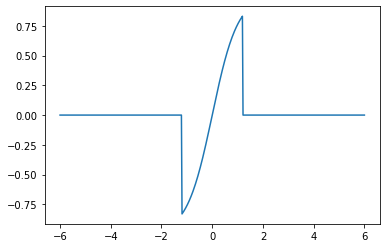

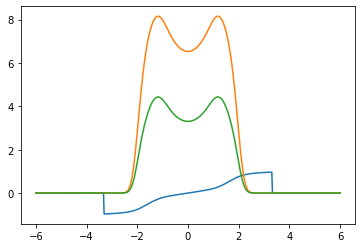

In [19]:
# Main Execution
if __name__ == "__main__":
    t0, nt, dx, dt, E, u, n = initialize_conditions('square_pulse')
    plt.plot(eta,u)
    plt.show()
    u, e, n, eps_p, Landau_p = flow2(t0, u, E, n)
    plt.plot(eta,u)
    plt.plot(eta,n)
    plt.plot(eta,e)
    plt.show()
    #plot_bjorken_solution(eps_p)
    #plot_landau_solution(eta,eps_p,Landau_p)